Loading data...
Dataset shape: (15744, 58)
Columns: ['map_id_31', 'map_id_32', 'map_id_33', 'map_id_34', 'map_id_35', 'map_id_40', 'map_id_46', 'map_id_47', 'map_id_48', 'team_a_wins_vs_b', 'team_a_losses_vs_b', 'team_a_total_vs_b', 'team_a_winrate_vs_b', 'team_a_map_wins', 'team_a_map_losses', 'team_a_map_total', 'team_a_map_winrate', 'team_b_map_wins', 'team_b_map_losses', 'team_b_map_total', 'team_b_map_winrate', 'team_a_win_streak', 'team_a_loss_streak', 'team_b_win_streak', 'team_b_loss_streak', 'team_a_player1_overall_rating', 'team_a_player1_utility_success', 'team_a_player1_opening_rating', 'team_a_player2_overall_rating', 'team_a_player2_utility_success', 'team_a_player2_opening_rating', 'team_a_player3_overall_rating', 'team_a_player3_utility_success', 'team_a_player3_opening_rating', 'team_a_player4_overall_rating', 'team_a_player4_utility_success', 'team_a_player4_opening_rating', 'team_a_player5_overall_rating', 'team_a_player5_utility_success', 'team_a_player5_opening_rat

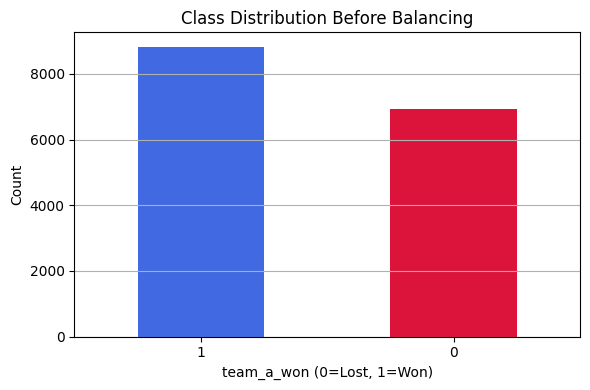


BALANCING CLASSES (removing excess data from majority class)
Minority class (0): 6918 samples
Majority class (1): 8826 samples
Will keep 6918 samples from each class

After balancing:
  Total samples: 13836 (removed 1908 samples)
  New target distribution:
team_a_won
1    6918
0    6918
Name: count, dtype: int64
  New target percentage:
team_a_won
1    50.0
0    50.0
Name: proportion, dtype: float64


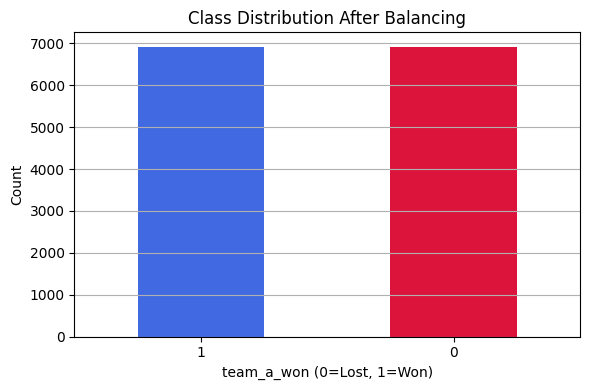


----- Baseline Analysis: After Balancing -----
Balanced class counts:
team_a_won
1    6918
0    6918
Name: count, dtype: int64

Balanced class percentages:
team_a_won
1    50.0
0    50.0
Name: proportion, dtype: float64

Baseline accuracy with balanced data: 50.00%


Train set: 11068 samples
Train set class distribution:
team_a_won
1    5534
0    5534
Name: count, dtype: int64
Train set class percentage:
team_a_won
1    50.0
0    50.0
Name: proportion, dtype: float64

Test set: 2768 samples
Test set class distribution:
team_a_won
1    1384
0    1384
Name: count, dtype: int64
Test set class percentage:
team_a_won
1    50.0
0    50.0
Name: proportion, dtype: float64

Input feature size: 57


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, adjusted_rand_score
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns  # add this at the top if not already imported

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration flag: Set to True to balance classes (equal split)
BALANCE_CLASSES = True

# Define paths
project_root = Path().resolve().parent
data_file = project_root / "data" / "preprocessed_data" / "final_features.csv"

print("Loading data...")
# Load the data
df = pd.read_csv(data_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Separate features and target
target_col = 'team_a_won'
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\nFeatures: {X.shape[1]} columns")
print(f"Original target distribution:")
print(y.value_counts())
print(f"\nOriginal target percentage:")
print(y.value_counts(normalize=True) * 100)

plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color=['royalblue', 'crimson'])
plt.title('Class Distribution Before Balancing')
plt.xlabel('team_a_won (0=Lost, 1=Won)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Balance classes if flag is set
if BALANCE_CLASSES:
    print(f"\n{'='*60}")
    print("BALANCING CLASSES (removing excess data from majority class)")
    print(f"{'='*60}")
    
    # Combine X and y for balancing
    df_combined = pd.concat([X, y], axis=1)
    
    # Get class counts
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    minority_count = class_counts.min()
    
    print(f"Minority class ({minority_class}): {minority_count} samples")
    print(f"Majority class ({majority_class}): {class_counts.max()} samples")
    print(f"Will keep {minority_count} samples from each class")
    
    # Separate by class
    df_minority = df_combined[df_combined[target_col] == minority_class]
    df_majority = df_combined[df_combined[target_col] == majority_class]
    
    # Randomly sample from majority class to match minority class size
    df_majority_balanced = df_majority.sample(n=minority_count, random_state=42)
    
    # Combine balanced classes
    df_balanced = pd.concat([df_minority, df_majority_balanced], ignore_index=True)
    
    # Shuffle the balanced dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Separate back into X and y
    X = df_balanced.drop(columns=[target_col])
    y = df_balanced[target_col]
    
    print(f"\nAfter balancing:")
    print(f"  Total samples: {len(df_balanced)} (removed {len(df) - len(df_balanced)} samples)")
    print(f"  New target distribution:")
    print(y.value_counts())
    print(f"  New target percentage:")
    print(y.value_counts(normalize=True) * 100)
    # --- Baseline analysis and visualization after balancing ---
    plt.figure(figsize=(6,4))
    y.value_counts().plot(kind='bar', color=['royalblue', 'crimson'])
    plt.title('Class Distribution After Balancing')
    plt.xlabel('team_a_won (0=Lost, 1=Won)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    print("\n----- Baseline Analysis: After Balancing -----")
    balanced_class_counts = y.value_counts()
    balanced_class_percentages = y.value_counts(normalize=True) * 100
    print(f"Balanced class counts:\n{balanced_class_counts}\n")
    print(f"Balanced class percentages:\n{balanced_class_percentages}\n")
    print(f"Baseline accuracy with balanced data: {balanced_class_percentages.max():.2f}%\n")

else:
    print(f"\nBALANCE_CLASSES is False - using original imbalanced dataset")

# Split into train and test sets (80/20) with stratification to maintain balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Train set class distribution:")
print(y_train.value_counts())
print(f"Train set class percentage:")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"Test set class distribution:")
print(y_test.value_counts())
print(f"Test set class percentage:")
print(y_test.value_counts(normalize=True) * 100)

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

print(f"\nInput feature size: {X_train_tensor.shape[1]}")

In [13]:
# Define the Neural Network
class MatchPredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(MatchPredictor, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer (binary classification)
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize model
input_size = X_train_tensor.shape[1]
model = MatchPredictor(input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
MatchPredictor(
  (model): Sequential(
    (0): Linear(in_features=57, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

Total parameters: 18,241


In [14]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training parameters
num_epochs = 100
batch_size = 128
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"\nStarting training for {num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Using device: cpu

Starting training for 100 epochs...
Batch size: 128
Learning rate: 0.001


In [15]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    avg_train_loss = train_loss / (len(X_train_tensor) // batch_size + 1)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_predicted = (val_outputs > 0.5).float()
        val_correct = (val_predicted == y_test_tensor).sum().item()
        val_accuracy = 100 * val_correct / len(y_test_tensor)
        
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)
    
    # Learning rate scheduling
    scheduler.step(val_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.2f}%')
        print()

Epoch [1/100]
  Train Loss: 0.6796, Train Acc: 58.65%
  Val Loss: 0.6424, Val Acc: 63.19%

Epoch [10/100]
  Train Loss: 0.6256, Train Acc: 65.12%
  Val Loss: 0.6367, Val Acc: 64.63%

Epoch [20/100]
  Train Loss: 0.6032, Train Acc: 67.25%
  Val Loss: 0.6447, Val Acc: 63.51%

Epoch [30/100]
  Train Loss: 0.5932, Train Acc: 67.35%
  Val Loss: 0.6501, Val Acc: 63.01%

Epoch [40/100]
  Train Loss: 0.5906, Train Acc: 68.05%
  Val Loss: 0.6509, Val Acc: 63.26%

Epoch [50/100]
  Train Loss: 0.5922, Train Acc: 68.12%
  Val Loss: 0.6514, Val Acc: 63.44%

Epoch [60/100]
  Train Loss: 0.5871, Train Acc: 68.53%
  Val Loss: 0.6525, Val Acc: 63.19%

Epoch [70/100]
  Train Loss: 0.5880, Train Acc: 68.17%
  Val Loss: 0.6516, Val Acc: 63.29%

Epoch [80/100]
  Train Loss: 0.5919, Train Acc: 67.92%
  Val Loss: 0.6517, Val Acc: 63.01%

Epoch [90/100]
  Train Loss: 0.5921, Train Acc: 68.37%
  Val Loss: 0.6522, Val Acc: 63.33%

Epoch [100/100]
  Train Loss: 0.5893, Train Acc: 68.31%
  Val Loss: 0.6519, Val A

In [16]:
# Final evaluation
model.eval()
with torch.no_grad():
    # Get predictions
    train_outputs = model(X_train_tensor)
    train_predicted = (train_outputs > 0.5).float().cpu().numpy()
    
    test_outputs = model(X_test_tensor)
    test_predicted = (test_outputs > 0.5).float().cpu().numpy()
    test_probs = test_outputs.cpu().numpy()

# Convert to numpy for sklearn metrics
y_train_np = y_train_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Calculate metrics
print("=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)

print("\nTRAIN SET METRICS:")
train_acc = accuracy_score(y_train_np, train_predicted)
train_prec = precision_score(y_train_np, train_predicted)
train_rec = recall_score(y_train_np, train_predicted)
train_f1 = f1_score(y_train_np, train_predicted)

print(f"Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Precision: {train_prec:.4f}")
print(f"Recall:    {train_rec:.4f}")
print(f"F1-Score:  {train_f1:.4f}")

print("\nTEST SET METRICS:")
test_acc = accuracy_score(y_test_np, test_predicted)
test_prec = precision_score(y_test_np, test_predicted)
test_rec = recall_score(y_test_np, test_predicted)
test_f1 = f1_score(y_test_np, test_predicted)

print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

print("\nCONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test_np, test_predicted)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Calculate ARI
ari = adjusted_rand_score(y_test_np.flatten(), test_predicted.flatten())
print(f"\nAdjusted Rand Index: {ari:.4f}")



print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test_np, test_predicted, target_names=['Team A Lost', 'Team A Won']))

FINAL MODEL EVALUATION

TRAIN SET METRICS:
Accuracy:  0.6979 (69.79%)
Precision: 0.6735
Recall:    0.7680
F1-Score:  0.7177

TEST SET METRICS:
Accuracy:  0.6340 (63.40%)
Precision: 0.6149
Recall:    0.7175
F1-Score:  0.6622

CONFUSION MATRIX (Test Set):
[[762 622]
 [391 993]]

True Negatives:  762
False Positives: 622
False Negatives: 391
True Positives:  993

Adjusted Rand Index: 0.0715

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

 Team A Lost       0.66      0.55      0.60      1384
  Team A Won       0.61      0.72      0.66      1384

    accuracy                           0.63      2768
   macro avg       0.64      0.63      0.63      2768
weighted avg       0.64      0.63      0.63      2768



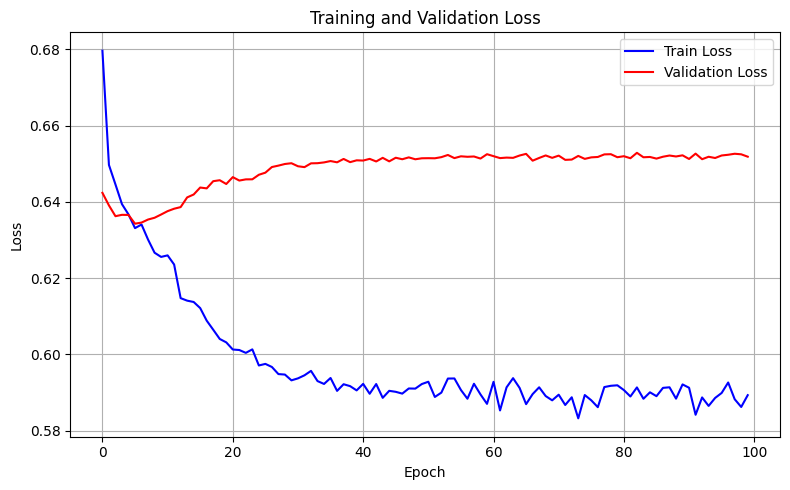

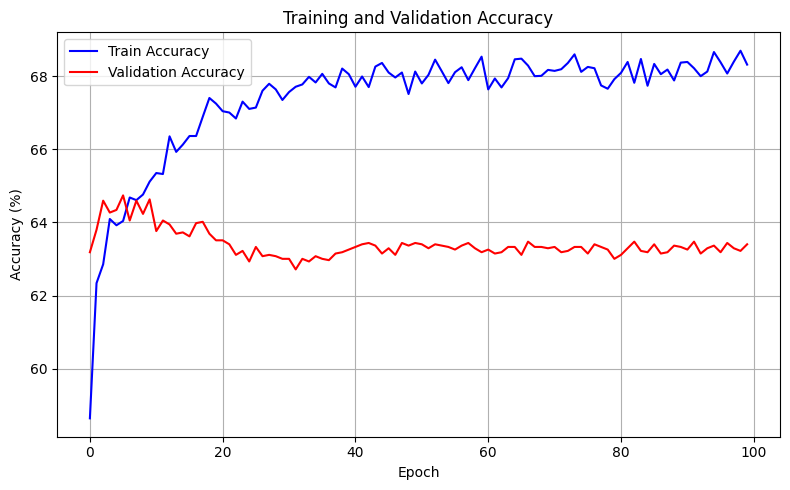

In [17]:
# Plot training history
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Loss plot
# axes[0].plot(train_losses, label='Train Loss', color='blue')
# axes[0].plot(val_losses, label='Validation Loss', color='red')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].set_title('Training and Validation Loss')
# axes[0].legend()
# axes[0].grid(True)

# # Accuracy plot
# axes[1].plot(train_accuracies, label='Train Accuracy', color='blue')
# axes[1].plot(val_accuracies, label='Validation Accuracy', color='red')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Accuracy (%)')
# axes[1].set_title('Training and Validation Accuracy')
# axes[1].legend()
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()

# print(f"\nBest validation accuracy: {max(val_accuracies):.2f}% at epoch {val_accuracies.index(max(val_accuracies)) + 1}")
# print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
